
# CareerCon 2019 - Help Navigate Robots
## Top Solutions Compilation

![](https://www.lextronic.fr/imageslib/4D/0J7589.320.gif)

---

Robots are smart… by design. To fully understand and properly navigate a task, however, they need input about their environment.

In this competition, you’ll help robots recognize the floor surface they’re standing on using data collected from Inertial Measurement Units (IMU sensors).

---

> This is just a **compilation** of all the best solutions I have found, different types of analysis and posts (discussions).
> **The purpose** of this is to have in a single kernel all the relevant information/solutions of this competition, so that if in the future there is a similar competition this material can be used as baseline, and maybe the authors delete the kernel or make it private, so we would lose all that amazing information.
> **Please** comment bellow if you want me to add something, or if I missed something important... and please support the original kernels and their authors.

My best/original kernel in this competition is [#1 Smart Robots. Most Complete Notebook 🤖](https://www.kaggle.com/jesucristo/1-smart-robots-most-complete-notebook)

### References

- [#16 Solution](https://www.kaggle.com/ilhamfp31/16-solution-0-76) by [@ilhamfp31](https://www.kaggle.com/ilhamfp31)
- [Submission (Fourier, Neighbour Detection, SVM)](https://www.kaggle.com/trohwer64/submission-fourier-neighbour-detection-svm/code) by [Thomas Rohwer](https://www.kaggle.com/trohwer64)
- [Starter Code for 3rd place Solution](https://www.kaggle.com/prith189/starter-code-for-3rd-place-solution)
- https://www.kaggle.com/ilhamfp31/16-solution-0-76
- https://www.kaggle.com/whoiskk/15-solution-private-0-77

<br>

# 1. Starter code: [#1 Smart Robots. Most Complete Notebook 🤖](https://www.kaggle.com/jesucristo/1-smart-robots-most-complete-notebook)

# 2. Basic Kernels

## [Simple Fourier Analysis](https://www.kaggle.com/trohwer64/simple-fourier-analysis) by [Thomas Rohwer](https://www.kaggle.com/trohwer64)

In [ ]:
!ls ../input

In [3]:
PATH = '../input/career-con-2019'

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import math
import gc
gc.enable()

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

train_x = pd.read_csv(PATH+'/X_train.csv')
train_y = pd.read_csv(PATH+'/y_train.csv')

In [ ]:
def prepare_data(t):
    def f(d):
        d=d.sort_values(by=['measurement_number'])
        return pd.DataFrame({
         'lx':[ d['linear_acceleration_X'].values ],
         'ly':[ d['linear_acceleration_Y'].values ],
         'lz':[ d['linear_acceleration_Z'].values ],
         'ax':[ d['angular_velocity_X'].values ],
         'ay':[ d['angular_velocity_Y'].values ],
         'az':[ d['angular_velocity_Z'].values ],
        })

    t= t.groupby('series_id').apply(f)

    def mfft(x):
        return [ x/math.sqrt(128.0) for x in np.absolute(np.fft.fft(x)) ][1:65]

    t['lx_f']=[ mfft(x) for x in t['lx'].values ]
    t['ly_f']=[ mfft(x) for x in t['ly'].values ]
    t['lz_f']=[ mfft(x) for x in t['lz'].values ]
    t['ax_f']=[ mfft(x) for x in t['ax'].values ]
    t['ay_f']=[ mfft(x) for x in t['ay'].values ]
    t['az_f']=[ mfft(x) for x in t['az'].values ]
    return t

t=prepare_data(train_x)

t=pd.merge(t,train_y[['series_id','surface','group_id']],on='series_id')
t=t.rename(columns={"surface": "y"})

def aggf(d, feature):
    va= np.array(d[feature].tolist())
    mean= sum(va)/va.shape[0]
    var= sum([ (va[i,:]-mean)**2 for i in range(va.shape[0]) ])/va.shape[0]
    dev= [ math.sqrt(x) for x in var ]
    return pd.DataFrame({
        'mean': [ mean ],
        'dev' : [ dev ],
    })

display={
'hard_tiles_large_space':'r-.',
'concrete':'g-.',
'tiled':'b-.',

'fine_concrete':'r-',
'wood':'g-',
'carpet':'b-',
'soft_pvc':'y-',

'hard_tiles':'r--',
'soft_tiles':'g--',
}

import matplotlib.pyplot as plt
plt.figure(figsize=(14, 8*7))
#plt.margins(x=0.0, y=0.0)
#plt.tight_layout()
# plt.figure()

features=['lx_f','ly_f','lz_f','ax_f','ay_f','az_f']
count=0

for feature in features:
    stat= t.groupby('y').apply(aggf,feature)
    stat.index= stat.index.droplevel(-1)
    b=[*range(len(stat.at['carpet','mean']))]

    count+=1
    plt.subplot(len(features)+1,1,count)
    for i,(k,v) in enumerate(display.items()):
        plt.plot(b, stat.at[k,'mean'], v, label=k)
        # plt.errorbar(b, stat.at[k,'mean'], yerr=stat.at[k,'dev'], fmt=v)
   
    leg = plt.legend(loc='best', ncol=3, mode="expand", shadow=True, fancybox=True)
    plt.title("sensor: " + feature)
    plt.xlabel("frequency component")
    plt.ylabel("amplitude")

count+=1
plt.subplot(len(features)+1,1,count)
k='concrete'
v=display[k]
feature='lz_f'
stat= t.groupby('y').apply(aggf,feature)
stat.index= stat.index.droplevel(-1)
b=[*range(len(stat.at['carpet','mean']))]

plt.errorbar(b, stat.at[k,'mean'], yerr=stat.at[k,'dev'], fmt=v)
plt.title("sample for error bars (lz_f, surface concrete)")
plt.xlabel("frequency component")
plt.ylabel("amplitude")

plt.show()

In [ ]:
del train_x, train_y 
gc.collect()

## [Deep Learning Starter](https://www.kaggle.com/theoviel/deep-learning-starter) by [Theo Viel](https://www.kaggle.com/theoviel)

In this kernel, Theo directly feed the data into a **Recurrent Neural Network**. For fancyness, Theo added an **Attention Mechanism**.



In [14]:
import os
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import math

from sklearn.metrics import *
from sklearn.model_selection import *

import keras
from keras.layers import *
from keras.callbacks import *
from keras.models import Model
from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints, optimizers, layers

In [4]:
X_train = pd.read_csv(PATH+"/X_train.csv")
X_test = pd.read_csv(PATH+"/X_test.csv")
y_train = pd.read_csv(PATH+"/y_train.csv")
sub = pd.read_csv(PATH+"/sample_submission.csv")

In [5]:
print ("Train: measurements = %d , features = %d" % X_train.shape)
X_train.head()

Train: measurements = 487680 , features = 13


,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410


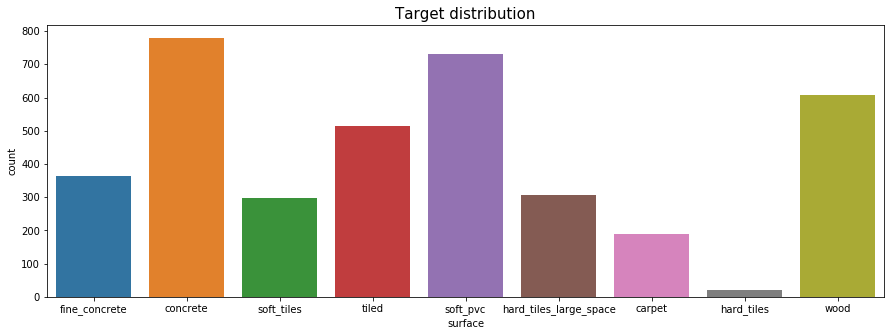

In [6]:
plt.figure(figsize=(15, 5))
sns.countplot(y_train['surface'])
plt.title('Target distribution', size=15)
plt.show()

**Input: Prepare data for the Neural Network**

In [7]:
X_train.drop(['row_id', "series_id", "measurement_number"], axis=1, inplace=True)
X_train = X_train.values.reshape((3810, 128, 10))

X_test.drop(['row_id', "series_id", "measurement_number"], axis=1, inplace=True)
X_test = X_test.values.reshape((3816, 128, 10))

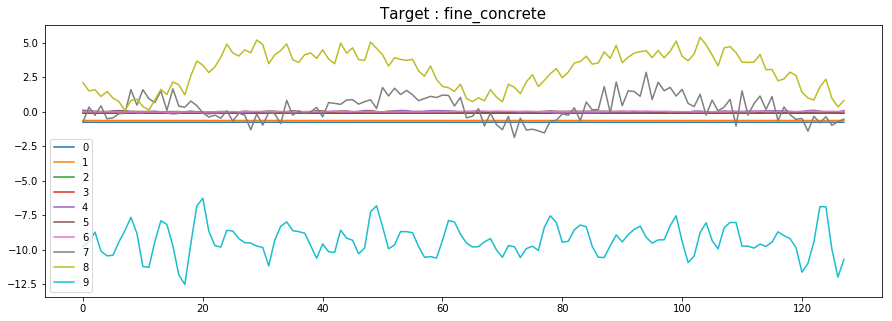

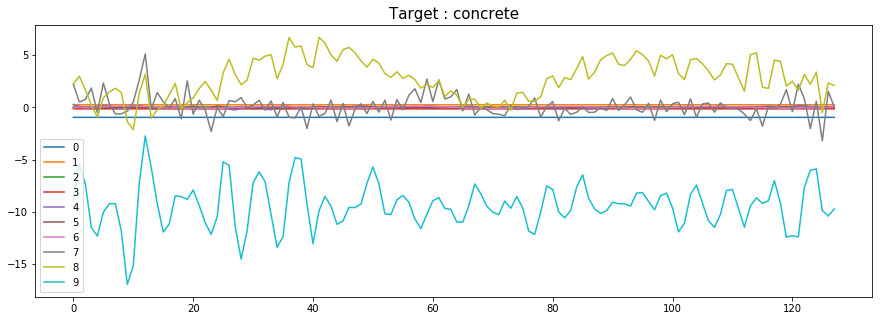

In [8]:
for j in range(2):
    plt.figure(figsize=(15, 5))
    plt.title("Target : " + y_train['surface'][j], size=15)
    for i in range(10):
        plt.plot(X_train[j, :, i], label=i)
    plt.legend()
    plt.show()

**Output: encode/decode target**

In [9]:
encode_dic = {'fine_concrete': 0, 
              'concrete': 1, 
              'soft_tiles': 2, 
              'tiled': 3, 
              'soft_pvc': 4,
              'hard_tiles_large_space': 5, 
              'carpet': 6, 
              'hard_tiles': 7, 
              'wood': 8}

decode_dic = {0: 'fine_concrete',
              1: 'concrete',
              2: 'soft_tiles',
              3: 'tiled',
              4: 'soft_pvc',
              5: 'hard_tiles_large_space',
              6: 'carpet',
              7: 'hard_tiles',
              8: 'wood'}

y_train = y_train['surface'].map(encode_dic).astype(int)

**Attention Layer**

In [16]:
class Attention(Layer):
    def __init__(self, step_dim, W_regularizer=None, b_regularizer=None, W_constraint=None, b_constraint=None, bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')
        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)
        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)
        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)
        
    def build(self, input_shape):
        assert len(input_shape) == 3
        self.W = self.add_weight((input_shape[-1],), initializer=self.init, name='{}_W'.format(self.name), regularizer=self.W_regularizer, constraint=self.W_constraint)
        self.features_dim = input_shape[-1]
        if self.bias:
            self.b = self.add_weight((input_shape[1],), initializer='zero', name='{}_b'.format(self.name), regularizer=self.b_regularizer, constraint=self.b_constraint)
        else:
            self.b = None
        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim
        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)), K.reshape(self.W, (features_dim, 1))), (-1, step_dim))
        if self.bias: eij += self.b
        eij = K.tanh(eij)
        a = K.exp(eij)
        if mask is not None: a *= K.cast(mask, K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim

**Model**

In [11]:
def make_model():
    inp = Input(shape=(128, 10))
    x = Bidirectional(CuDNNLSTM(32, return_sequences=True))(inp)
    x = Attention(128)(x)
    x = Dense(9, activation="softmax")(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

**K-Folds**

In [17]:
def k_folds(X, y, X_test, k=5):
    folds = list(StratifiedKFold(n_splits=k).split(X, y))
    y_test = np.zeros((X_test.shape[0], 9))
    y_oof = np.zeros((X.shape[0]))
    
    for i, (train_idx, val_idx) in  enumerate(folds):
        print(f"Fold {i+1}")
        model = make_model()
        model.fit(X[train_idx], y[train_idx], batch_size=64, epochs=75, 
                  validation_data=[X[val_idx], y[val_idx]], verbose=0)
        
        pred_val = np.argmax(model.predict(X[val_idx]), axis=1)
        score = accuracy_score(pred_val, y[val_idx])
        y_oof[val_idx] = pred_val
        
        print(f'Scored {score:.3f} on validation data')
        
        y_test += model.predict(X_test)
        
    return y_oof, y_test                               

In [18]:
y_oof, y_test = k_folds(X_train, y_train, X_test, k=5)

Fold 1


InvalidArgumentError: No OpKernel was registered to support Op 'CudnnRNN' used by node bidirectional_1/CudnnRNN (defined at /opt/conda/lib/python3.6/site-packages/keras/layers/cudnn_recurrent.py:517) with these attrs: [dropout=0, seed=87654321, input_mode="linear_input", T=DT_FLOAT, direction="unidirectional", rnn_mode="lstm", seed2=0, is_training=true]
Registered devices: [CPU, XLA_CPU]
Registered kernels:
  <no registered kernels>

	 [[node bidirectional_1/CudnnRNN (defined at /opt/conda/lib/python3.6/site-packages/keras/layers/cudnn_recurrent.py:517) ]]

Caused by op 'bidirectional_1/CudnnRNN', defined at:
  File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/opt/conda/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "/opt/conda/lib/python3.6/asyncio/base_events.py", line 422, in run_forever
    self._run_once()
  File "/opt/conda/lib/python3.6/asyncio/base_events.py", line 1434, in _run_once
    handle._run()
  File "/opt/conda/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/opt/conda/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 117, in _handle_events
    handler_func(fileobj, events)
  File "/opt/conda/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/opt/conda/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/opt/conda/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/opt/conda/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/opt/conda/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-1f29d5f4cee0>", line 1, in <module>
    y_oof, y_test = k_folds(X_train, y_train, X_test, k=5)
  File "<ipython-input-12-6b0563879304>", line 8, in k_folds
    model = make_model()
  File "<ipython-input-11-3df5c4991b14>", line 3, in make_model
    x = Bidirectional(CuDNNLSTM(32, return_sequences=True))(inp)
  File "/opt/conda/lib/python3.6/site-packages/keras/layers/wrappers.py", line 427, in __call__
    return super(Bidirectional, self).__call__(inputs, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/keras/engine/base_layer.py", line 457, in __call__
    output = self.call(inputs, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/keras/layers/wrappers.py", line 522, in call
    y = self.forward_layer.call(inputs, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/keras/layers/cudnn_recurrent.py", line 90, in call
    output, states = self._process_batch(inputs, initial_state)
  File "/opt/conda/lib/python3.6/site-packages/keras/layers/cudnn_recurrent.py", line 517, in _process_batch
    is_training=True)
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/contrib/cudnn_rnn/python/ops/cudnn_rnn_ops.py", line 1636, in __call__
    input_data, input_h, input_c, params, is_training=is_training)
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/contrib/cudnn_rnn/python/ops/cudnn_rnn_ops.py", line 1527, in __call__
    seed=self._seed)
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/contrib/cudnn_rnn/python/ops/cudnn_rnn_ops.py", line 1014, in _cudnn_rnn
    outputs, output_h, output_c, _ = gen_cudnn_rnn_ops.cudnn_rnn(**args)
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/gen_cudnn_rnn_ops.py", line 142, in cudnn_rnn
    seed2=seed2, is_training=is_training, name=name)
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3300, in create_op
    op_def=op_def)
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1801, in __init__
    self._traceback = tf_stack.extract_stack()

InvalidArgumentError (see above for traceback): No OpKernel was registered to support Op 'CudnnRNN' used by node bidirectional_1/CudnnRNN (defined at /opt/conda/lib/python3.6/site-packages/keras/layers/cudnn_recurrent.py:517) with these attrs: [dropout=0, seed=87654321, input_mode="linear_input", T=DT_FLOAT, direction="unidirectional", rnn_mode="lstm", seed2=0, is_training=true]
Registered devices: [CPU, XLA_CPU]
Registered kernels:
  <no registered kernels>

	 [[node bidirectional_1/CudnnRNN (defined at /opt/conda/lib/python3.6/site-packages/keras/layers/cudnn_recurrent.py:517) ]]


In [ ]:
print(f'Local CV is {accuracy_score(y_oof, y_train): .4f}')

**Submission**

In [ ]:
y_test = np.argmax(y_test, axis=1)
sub['surface'] = y_test
sub['surface'] = sub['surface'].map(decode_dic)
sub.head()
sub.to_csv('submission.csv', index=False)

**Thanks Theo!**

In [ ]:
gc.collect()

<br>
# 3. Top Solutions
<br>
## [The Missing Link...](https://www.kaggle.com/friedchips/the-missing-link) by [Markus F](https://www.kaggle.com/friedchips)

<br>
**Load packages**

In [ ]:
!ls ../input

In [ ]:
import numpy as np
import pandas as pd

from time import time

import matplotlib.pyplot as plt
import seaborn as sns
from seaborn import countplot,lineplot, barplot
%matplotlib inline

from scipy import stats
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.metrics import accuracy_score

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn import preprocessing
from scipy.stats import randint as sp_randint
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import random
import math

from numpy.fft import *
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.tools import FigureFactory as FF

le = preprocessing.LabelEncoder()

import os

import warnings
warnings.filterwarnings('ignore')

import gc
gc.enable()


In [ ]:
PATH = "../input/career-con-2019"

## [Starter Code for 3rd place Solution](https://www.kaggle.com/prith189/starter-code-for-3rd-place-solution/notebook) by [Prithvi](https://www.kaggle.com/prith189)

**Looad data**

In [ ]:
testing = True #Set this to true for submission/False for cross validation
X_train = pd.read_csv(PATH+'/X_train.csv')
y_train = pd.read_csv(PATH+'/y_train.csv')
X_train = pd.merge(X_train,y_train,on='series_id')
X_train['surface'] = le.fit_transform(X_train['surface'])

if(testing):
    X_test = pd.read_csv(PATH+'/X_test.csv')
    X_test['series_id'] = X_test['series_id']+3810
    X_test['group_id'] = 0
    X_test['surface'] = 0
    frames = [X_train,X_test]
    X_train = pd.concat(frames)
    X_train.reset_index(drop=True,inplace=True)

In [ ]:
X_train.head()

In [ ]:
X_test.head()

In [ ]:
cols = list(X_train.columns.values)
cols.remove('orientation_W')
cols.insert(3,'orientation_W')
X_train = X_train[cols]
print ("New train data")
X_train.head()

In [ ]:
num_meas = 128
num_series = X_train['series_id'].nunique()
print ("Number of measurements = ", num_meas)
print ("Number of total sereis = ", num_series)

**From quaternion to euler angles**

![](https://www.researchgate.net/publication/283951857/figure/fig2/AS:319897696522260@1453280962401/Roll-pitch-yaw-angles-of-cars-and-other-land-based-vehicles-10.png)

In [ ]:
def q_to_angle(q_val):
    #We assume q_val is in this format: [qw, q1, q2, q3]
    #And the quaternion is normalized
    roll = np.arctan2(2*(q_val[0]*q_val[1] + q_val[2]*q_val[3]),1 - 2*(q_val[1]*q_val[1] + q_val[2]*q_val[2]))
    pitch = np.arcsin(2*(q_val[0]*q_val[2] - q_val[3]*q_val[1]))
    yaw = np.arctan2(2*(q_val[0]*q_val[3] + q_val[1]*q_val[2]),1 - 2*(q_val[2]*q_val[2] + q_val[3]*q_val[3]))
    return np.array([roll, pitch, yaw])

In [ ]:
quat_arr = np.array(X_train[['orientation_W','orientation_X','orientation_Y','orientation_Z']])
euler_arr = np.zeros([quat_arr.shape[0],3])
for n,arr in enumerate(quat_arr):
    euler_arr[n] = q_to_angle(arr)

In [ ]:
X_train['roll'] = euler_arr[:,0]
X_train['pitch'] = euler_arr[:,1]
X_train['yaw'] = euler_arr[:,2]

In [ ]:
cols = list(X_train.columns.values)
cols.remove('group_id')
cols.append('group_id')
cols.remove('surface')
cols.append('surface')
X_train = X_train[cols]
print ("Train updated")
X_train.head()

In [ ]:
feat_cols = ['roll','pitch','yaw','angular_velocity_X','angular_velocity_Y','angular_velocity_Z','linear_acceleration_X','linear_acceleration_Y','linear_acceleration_Z']
feat_array = np.array(X_train[feat_cols])
feat_array = np.reshape(feat_array,[num_series,128,len(feat_cols)])
group_array = np.array(X_train['group_id'])
group_array = np.reshape(group_array,[num_series,128])
group_array = group_array[:,0]
target_array = np.array(X_train['surface'])
target_array = np.reshape(target_array,[num_series,128])
target_array = target_array[:,0]

In [ ]:
#Use the first order difference of the following features
#Absolute Orientation features dont make sense to predict surface
delta_cols = ['roll','pitch','yaw']
for dc in delta_cols:
    iia = feat_cols.index(dc)
    np_arr = feat_array[:,:,iia]
    roll_arr = np.copy(np_arr)
    roll_arr[:,1:] = roll_arr[:,:-1]
    np_arr = np_arr - roll_arr
    feat_array[:,:,iia] = np_arr

Normalize each 128-pt sample to ensure there is no group related information left in the samples

In [ ]:
norm_cols = ['linear_acceleration_X','linear_acceleration_Y','linear_acceleration_Z','angular_velocity_X','angular_velocity_Y','angular_velocity_Z']
for norm in norm_cols:
    iia = feat_cols.index(norm)
    np_arr = feat_array[:,:,iia]
    mean_arr = np.mean(np_arr,1)
    mean_arr = np.expand_dims(mean_arr,1)
    mean_arr = np.repeat(mean_arr,num_meas,1)
    np_arr = np_arr - mean_arr
    feat_array[:,:,iia] = np_arr


In [ ]:
def absfft(x):
    return np.abs(np.fft.rfft(x))

feat_fft_array = np.copy(feat_array[:,:,3:])
feat_fft_array = np.apply_along_axis(absfft,1,feat_fft_array)

Further normalization across the entire dataset to ensure NN inputs are zero-mean and unit standard deviation

In [ ]:
num_sensor = feat_array.shape[2]
for i in range(num_sensor):
    mean_s = np.mean(feat_array[:,:,i])
    sd_s = np.std(feat_array[:,:,i])
    feat_array[:,:,i] = (feat_array[:,:,i]-mean_s)/sd_s

num_sensor_fft = feat_fft_array.shape[2]
for i in range(num_sensor_fft):
    mean_s = np.mean(feat_fft_array[:,:,i])
    sd_s = np.std(feat_fft_array[:,:,i])
    feat_fft_array[:,:,i] = (feat_fft_array[:,:,i]-mean_s)/sd_s

### Create NN Model

In [ ]:
from keras.layers import Input,Dense, Dropout, BatchNormalization, SeparableConv1D, Reshape, LSTM, DepthwiseConv2D,AveragePooling2D, CuDNNLSTM, Concatenate
from keras.models import Model
from keras.backend import squeeze
from keras.regularizers import l2

In [ ]:
kr = None
num_groups = np.unique(group_array).shape[0]
num_surfaces = np.unique(target_array).shape[0]

def get_net_with_fft_mag_only(dp):
    inputs_t = Input(shape=(128,len(feat_cols)))
    x = SeparableConv1D(32,8,2,'same',depth_multiplier=1,activation='relu',kernel_regularizer=kr)(inputs_t)
    x = Dropout(dp)(x)
    x = SeparableConv1D(64,8,4,'same',depth_multiplier=1,activation='relu',kernel_regularizer=kr)(x)
    x = Dropout(dp)(x)
    x = SeparableConv1D(128,8,4,'same',depth_multiplier=1,activation='relu',kernel_regularizer=kr)(x)
    x = Dropout(dp)(x)
    x = SeparableConv1D(256,8,4,'same',depth_multiplier=1,activation='relu',kernel_regularizer=kr)(x)
    x = Reshape((256,))(x)
    x = Dropout(dp)(x)
    x = Dense(64, activation='relu',kernel_regularizer=kr)(x)
    x = Dropout(dp)(x)
    x = Dense(64, activation='relu')(x)
    
    inputs_f = Input(shape=(feat_fft_array.shape[1],feat_fft_array.shape[2]))
    y = SeparableConv1D(32,8,2,'same',depth_multiplier=1,activation='relu',kernel_regularizer=kr)(inputs_f)
    y = Dropout(dp)(y)
    y = SeparableConv1D(64,8,2,'same',depth_multiplier=1,activation='relu',kernel_regularizer=kr)(y)
    y = Dropout(dp)(y)
    y = SeparableConv1D(128,8,4,'same',depth_multiplier=1,activation='relu',kernel_regularizer=kr)(y)
    y = Dropout(dp)(y)
    y = SeparableConv1D(128,8,4,'same',depth_multiplier=1,activation='relu',kernel_regularizer=kr)(y)
    y = Dropout(dp)(y)
    y = SeparableConv1D(256,8,2,'same',depth_multiplier=1,activation='relu',kernel_regularizer=kr)(y)
    y = Reshape((256,))(y)
    y = Dropout(dp)(y)
    y = Dense(64, activation='relu',kernel_regularizer=kr)(y)
    y = Dropout(dp)(y)
    y = Dense(64, activation='relu')(y)
    
        
    inputs = [inputs_t,inputs_f]
    
    z = Concatenate()([x,y])
    z = Dense(64, activation='relu')(z)
    predictions = Dense(num_surfaces, activation='softmax')(z)
    model = Model(inputs=inputs, outputs=predictions)
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

### Run NN + Group K-fold

In [ ]:
from sklearn.model_selection import GroupKFold, StratifiedKFold
from sklearn.metrics import accuracy_score
depthwise = False
fft_net = True
if(not(testing)):
    gkf = GroupKFold(3)
    train_gen = gkf.split(X=feat_array,groups=group_array)
    preds = np.zeros_like(target_array)
    for train_idx,test_idx in train_gen:
        #Test features
        t_feats = feat_array[train_idx]
        t_feats_fft = feat_fft_array[train_idx]
        
        #Validation features
        v_feats = feat_array[test_idx]
        v_feats_fft = feat_fft_array[test_idx]
        
        t_vals = target_array[train_idx]
        v_vals = target_array[test_idx]
        
        pred_classes = np.zeros([v_vals.shape[0],num_surfaces,5])
        for k in range(5): #5 time averaging to get more stable results
            nnet = get_net_with_fft_mag_only(0.5)
            nnet.fit(x=[t_feats,t_feats_fft],y=t_vals,batch_size=256,epochs=3000,validation_data=([v_feats,v_feats_fft],v_vals),verbose=2)
            pred_classes[:,:,k] = nnet.predict([v_feats,v_feats_fft])
        pred_classes = np.mean(pred_classes,axis=2)
        pred_classes = np.argmax(pred_classes,axis=1)
        preds[test_idx] = pred_classes
        print('Val accuracy: ',accuracy_score(v_vals,pred_classes))
        pred_classes = nnet.predict([t_feats,t_feats_fft])
        pred_classes = np.argmax(pred_classes,axis=1)
        print('Train accuracy: ',accuracy_score(t_vals,pred_classes))
    print('5 Fold accuracy: ', accuracy_score(target_array,preds))
else:
    t_feats = feat_array[:3810]
    t_feats_fft = feat_fft_array[:3810]
    t_vals = target_array[:3810]
    v_feats = feat_array[3810:]
    v_feats_fft = feat_fft_array[3810:]
    pred_classes = np.zeros([v_feats.shape[0],num_surfaces,3])
    for k in range(3):
        nnet = get_net_with_fft_mag_only(0.5)
        nnet.fit(x=[t_feats,t_feats_fft],y=t_vals,batch_size=256,epochs=3000,verbose=0)
        pred_classes[:,:,k] = nnet.predict([v_feats,v_feats_fft])
    pred_classes = np.mean(pred_classes,axis=2)
    pred_classes = list(np.argmax(pred_classes,axis=1))
    pred_classes = [le.inverse_transform([i])[0] for i in pred_classes]
    sub_df = pd.read_csv(PATH+'/sample_submission.csv')
    sub_df['surface'] = pred_classes
    sub_df.to_csv('submission.csv',index=False)

In [ ]:
gc.collect()

<br>
## [NN+LSTM,fft+features](https://www.kaggle.com/skondrash/nn-lstm-fft-features?scriptVersionId=12728595) by [Sergey K.](https://www.kaggle.com/skondrash)

**Load packages**

In [ ]:
from collections import Counter
from sklearn.neighbors import KNeighborsClassifier
from keras.layers import LSTM,Input,Dense,Flatten,SpatialDropout1D,Dropout,CuDNNLSTM,Reshape,Concatenate
from keras.layers import Lambda,concatenate,BatchNormalization
from keras.models import Model
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras import backend as K 
from sklearn.preprocessing import LabelEncoder

**Load data**

In [ ]:
directory = "../input/career-con-2019/"
X_test_path = os.path.join(directory,"X_test.csv")
X_train_path = os.path.join(directory,"X_train.csv")
X_test_data = pd.read_csv(X_test_path)
X_train_data = pd.read_csv(X_train_path)
y_train_data = pd.read_csv(os.path.join(directory,"y_train.csv"))
sample_submission = pd.read_csv(os.path.join(directory,"sample_submission.csv"))

In [ ]:
print ("Train data: measurements = %d , features=%d" %X_train_data.shape)
X_train_data.head()

In [ ]:
print ("Test data: measurements = %d , features=%d" %X_test_data.shape)
X_test_data.head()

Converting class labels to binary matrix representation

In [ ]:
le = LabelEncoder()
le.fit(list(y_train_data["surface"]))
y_train_dataset_for_nn = to_categorical(le.transform(list(y_train_data["surface"])))

Creating X-datasets for LSTM - shape = (num_samples,128,10)

In [ ]:
def dataset_for_nn(X_dataset):
    num_samples = X_dataset.shape[0]//128
    X_dataset_for_nn = np.zeros((num_samples,128,10))
    for i in range(num_samples):
        subset = np.array(X_dataset.iloc[i*128:(i+1)*128,3:])
        X_dataset_for_nn[i,:,:] = subset
    return X_dataset_for_nn

In [ ]:
X_train_for_nn = dataset_for_nn(X_train_data)
X_test_for_nn = dataset_for_nn(X_test_data)

In [ ]:
print ("Train data for NN")
X_train_for_nn[0]

Function for extracting Fourier transform with averaging

In [ ]:
def freqs(dataset,width):
    X = np.abs(fftpack.fft(dataset))
    squeezed_dataset = []
    for i in range(64//width):
        squeezed_dataset.append(np.mean(X[i*width:(i+1)*width]))
    return squeezed_dataset

Creating features

In [ ]:
def X_features(X_dataset,width=3):
    num_samples = len(list(set(X_dataset["series_id"])))
    num_cols = 64//width
    features = np.zeros((num_samples,40+10*num_cols))
    for i in range(num_samples):
        X_train_subset = np.array(X_dataset.iloc[i*128:(i+1)*128,3:])
        features[i,:10] = np.mean(X_train_subset,axis=0)
        features[i,10:20] = np.std(X_train_subset,axis=0)
        features[i,20:30] = np.max(X_train_subset,axis=0)-np.min(X_train_subset,axis=0)
        features[i,30:40] = X_train_subset[-1,:]-X_train_subset[0,:]
        for j in range(X_train_subset.shape[1]):
            features[i,40+j*num_cols:40+(j+1)*num_cols] = freqs(X_train_subset[:,j],width)
    return features

In [ ]:
X_train_features = X_features(X_train_data)
X_test_features = X_features(X_test_data)

Neural network architecture LSTM

In [ ]:
def LSTM_NN(drop):
    inp = Input(shape=(128,10))
    x = SpatialDropout1D(0.1)(inp)
    inp_2 = Input(shape=(250,))
    x_2 = Dense(250, input_shape=(250,), activation="sigmoid")(inp_2)
    x_2 = Dropout(drop)(x_2)
    x_2 = Dense(120, activation="sigmoid")(x_2)
    x_2 = Dropout(drop)(x_2)
    x_2 = Dense(60, activation="sigmoid")(x_2)
    x_2 = Dropout(drop)(x_2)
    x_2 = BatchNormalization()(x_2)
    x = CuDNNLSTM(units=200, return_sequences=True, return_state=False, go_backwards=False)(x)
    x = Dropout(drop)(x)
    x = CuDNNLSTM(units=100, return_sequences=False, return_state=False, go_backwards=False)(x)
    x = concatenate([x,x_2])
    x = Dropout(drop)(x)
    outp = Dense(9, activation="sigmoid")(x)
    model = Model(inputs=[inp,inp_2], outputs=outp)
    model.compile(loss='categorical_crossentropy', optimizer=Adam())
    return model

**Training model and prediction**

In [ ]:
%%time
n_splits=5
kfold = StratifiedKFold(n_splits=n_splits, random_state=10, shuffle=True)
y_test = np.zeros((X_test_for_nn.shape[0],9*n_splits))
train_preds = np.zeros((X_train_for_nn.shape[0],9))
X = X_train_for_nn
X_test = X_test_for_nn
Y = np.array(list(y_train_data["surface"]))
for i, (train_index, valid_index) in enumerate(kfold.split(X, Y)):
    X_train, X_val =  X[list(train_index),:,:],X[list(valid_index),:,:]
    X_train_feat, X_val_feat = X_train_features[list(train_index),:],X_train_features[list(valid_index),:]
    Y_train, Y_val = Y[list(train_index)], Y[list(valid_index)]
    Y_train = to_categorical(le.transform(Y_train))
    Y_val = to_categorical(le.transform(Y_val))
    model = LSTM_NN(0.15)
    model.fit([X_train,X_train_feat], Y_train, epochs=120, validation_data=([X_val,X_val_feat], Y_val), verbose=2) 
    y_pred = model.predict([X_val,X_val_feat], verbose=2)
    y_test[:,i*9:(i+1)*9] = model.predict([X_test,X_test_features])
    train_preds[list(valid_index),:] = np.squeeze(y_pred)

**CV Score**

In [ ]:
res_train = np.argmax(train_preds,axis=1)
ans_train = np.argmax(to_categorical(le.transform(Y)),axis=1)
print ("CV score",round(accuracy_score(res_train,ans_train),4))


**Exctracting test prediction (most frequent)**

In [ ]:
def most_frequent(List): 
    occurence_count = Counter(List) 
    return occurence_count.most_common(1)[0][0]

res_test_inter = np.zeros((y_test.shape[0],n_splits))
res_test=[]
for i in range(n_splits):
    inter_arr = y_test[:,i*9:(i+1)*9]
    res_test_inter[:,i] = np.argmax(inter_arr,axis=1)
for j in range(y_test.shape[0]):
    res_test.append(int(most_frequent(res_test_inter[j,:])))

**Submission**

In [ ]:
test_for_sub=le.inverse_transform(res_test)
print (test_for_sub[:5])
test_size = len(list(set(X_test_data["series_id"])))
Y_test_pred_array = np.zeros((test_size,2))
Y_test_for_submission = pd.DataFrame(Y_test_pred_array,columns = ["series_id","surface"])
Y_test_for_submission.iloc[:,0] = list(range(test_size))
Y_test_for_submission.iloc[:,1] = test_for_sub
Y_test_for_submission.to_csv("submission.csv",index=None)
Y_test_for_submission.head()

In [ ]:
gc.collect()

## [My solution](https://www.kaggle.com/ilhamfp31/16-solution-0-76) by  Ilham Firdausi Putra

**Load data**

In [ ]:
!ls ../input/

In [ ]:
data_target = pd.read_csv(PATH+"/y_train.csv")
train_X = pd.read_csv(PATH+'/X_train.csv').iloc[:,3:]
test_X  = pd.read_csv(PATH+'/X_test.csv').iloc[:,3:]

In [ ]:
train_X.head()

In [ ]:
train_X = train_X.append(test_X)
train_X = train_X.values.reshape(-1,128,10)

In [ ]:
train_X[0]

In [ ]:
test_X.head()

Like what Markus F said in his kernel [The missing link](https://www.kaggle.com/friedchips/the-missing-link)
, we can reconstruct the original data before it's being splitted.

Apparently, some of the original data is being splitted between train and test data. So here we go:

In [ ]:
# Originally from Markus F's kernel: https://www.kaggle.com/friedchips/the-missing-link
def sq_dist(a,b):
    ''' the squared euclidean distance between two samples '''
    
    return np.sum((a-b)**2, axis=1)


def find_run_edges(data, edge):
    ''' examine links between samples. left/right run edges are those samples which do not have a link on that side. '''

    if edge == 'left':
        border1 = 0
        border2 = -1
    elif edge == 'right':
        border1 = -1
        border2 = 0
    else:
        return False
    
    edge_list = []
    linked_list = []
    
    for i in range(len(data)):
        dist_list = sq_dist(data[i, border1, :4], data[:, border2, :4]) # distances to rest of samples
        min_dist = np.min(dist_list)
        closest_i   = np.argmin(dist_list) # this is i's closest neighbor
        if closest_i == i: # this might happen and it's definitely wrong
            print('Sample', i, 'linked with itself. Next closest sample used instead.')
            closest_i = np.argsort(dist_list)[1]
        dist_list = sq_dist(data[closest_i, border2, :4], data[:, border1, :4]) # now find closest_i's closest neighbor
        rev_dist = np.min(dist_list)
        closest_rev = np.argmin(dist_list) # here it is
        if closest_rev == closest_i: # again a check
            print('Sample', i, '(back-)linked with itself. Next closest sample used instead.')
            closest_rev = np.argsort(dist_list)[1]
        if (i != closest_rev): # we found an edge
            edge_list.append(i)
        else:
            linked_list.append([i, closest_i, min_dist])
            
    return edge_list, linked_list


def find_runs(data, left_edges, right_edges):
    ''' go through the list of samples & link the closest neighbors into a single run '''
    
    data_runs = []

    for start_point in left_edges:
        i = start_point
        run_list = [i]
        while i not in right_edges:
            tmp = np.argmin(sq_dist(data[i, -1, :4], data[:, 0, :4]))
            if tmp == i: # self-linked sample
                tmp = np.argsort(sq_dist(data[i, -1, :4], data[:, 0, :4]))[1]
            i = tmp
            run_list.append(i)
        data_runs.append(np.array(run_list))
    
    return data_runs

**Find the edges Part I**

In [ ]:
train_left_edges, train_left_linked  = find_run_edges(train_X, edge='left')
train_right_edges, train_right_linked = find_run_edges(train_X, edge='right')
print('Found', len(train_left_edges), 'left edges and', len(train_right_edges), 'right edges.')

**Find the runs Part I**

In [ ]:
train_runs = find_runs(train_X, train_left_edges, train_right_edges)

Let's find the missing samples from test data

In [ ]:
lost_samples = np.array([ i for i in range(len(train_X)) if i not in np.concatenate(train_runs) ])
print(lost_samples)
print(len(lost_samples))


In [ ]:
find_run_edges(train_X[lost_samples], edge='left')[1][0]
lost_run = np.array(lost_samples[find_runs(train_X[lost_samples], [0], [5])[0]])
train_runs.append(lost_run)

As what have been said in Markus F's kernel, there is some train runs (4) having more than 1 surface. We need to separate in manually. In order to do this, we need to track the runs in which the mis-allocated series lies.

In [ ]:
first_double_surface = 0
for i in range(0, len(train_runs)):
    for x in train_runs[i]:
        if x==821:
            print(i)
            first_double_surface = i

In [ ]:
train_runs[first_double_surface]

In [ ]:
new_train_runs = [821,  974,  328, 1548,  172,
        355,  957, 1481, 1046, 1650,  857,  724,  164, 1092, 1017, 1300,
       1212,  536,  531, 1032,  994, 1501,  588,  579, 1177,  812, 1333,
       1253]

train_runs[first_double_surface] = train_runs[first_double_surface][0:-len(new_train_runs)]

In [ ]:
train_runs.append(np.array(new_train_runs))

In [ ]:
second_double_surface = 0
for i in range(0, len(train_runs)):
    for x in train_runs[i]:
        if x==3055:
            print(i)
            second_double_surface = i

In [ ]:
train_runs[second_double_surface]

In [ ]:
new_train_runs2 = [3055, 3360, 3662,
       3780, 3663, 3091, 3769, 3175, 1957, 2712, 2063, 2708, 3139, 2722]

train_runs[second_double_surface] = train_runs[second_double_surface][0:-len(new_train_runs2)]

In [ ]:
train_runs.append(np.array(new_train_runs2))

In [ ]:
third_double_surface = 0
for i in range(0, len(train_runs)):
    for x in train_runs[i]:
        if x==2484:
            print(i)
            third_double_surface = i

In [ ]:
train_runs[third_double_surface]

In [ ]:
new_train_runs3 = [2484, 3062, 2290, 3517, 3293, 2651, 3767,
       2029, 2558, 3580, 1874, 3373, 2514, 2308, 3160, 3161, 3613, 2511,
       2469, 2990, 2780, 3756, 2376, 2616, 2540, 2039, 2219, 3743, 3198,
       2584, 2752, 2304, 2887, 2841, 3480, 2517, 3020, 3424, 2027, 2652,
       2648, 3433, 2359, 3392, 3164, 3798, 3642, 2713, 3405, 3673, 2369,
       3411, 3595, 2242, 2307, 1897, 2834, 2350, 3795, 2948, 1856, 3486,
       3353, 1966]

train_runs[third_double_surface] = train_runs[third_double_surface][0:-len(new_train_runs3)]
train_runs.append(np.array(new_train_runs3))

In [ ]:
fourth_double_surface = 0
for i in range(0, len(train_runs)):
    for x in train_runs[i]:
        if x==3501:
            print(i)
            fourth_double_surface = i

In [ ]:
train_runs[fourth_double_surface]

In [ ]:
new_train_runs4 = [3501, 2785]
train_runs[fourth_double_surface] = train_runs[fourth_double_surface][0:-len(new_train_runs4)]
train_runs.append(np.array(new_train_runs4))

After we remove the double surface runs, let's add this knowledge to our train_y.

In [ ]:
df_train_y = pd.DataFrame()
df_train_y['run_id'] = 0
df_train_y['run_pos'] = 0

for run_id in range(len(train_runs)):
    for run_pos in range(len(train_runs[run_id])):
        series_id = train_runs[run_id][run_pos]
        df_train_y.at[ series_id, 'run_id'  ] = run_id
        df_train_y.at[ series_id, 'run_pos' ] = run_pos

df_train_y.tail()

Rename index as series_id.

In [ ]:
df_train_y['index'] = df_train_y.index
df_train_y = df_train_y.sort_values('index')
df_train_y.rename(columns={'index':'series_id'}, inplace=True)
df_train_y['run_id'] = df_train_y['run_id'].apply(lambda x: int(x))
df_train_y['run_pos'] = df_train_y['run_pos'].apply(lambda x: int(x))
df_train_y.tail()

Now let's separate train and test.

In [ ]:
run_id_train = df_train_y['run_id'][0:3810].values
run_id_test = df_train_y['run_id'][3810:7626].values

Because some runs is linked between train and test data, we can essentially use train's target to map our test's target.

In [ ]:
data_target['run_id'] = run_id_train
mapping_leak = {}
for i in range(0,3810):
    cur_data = data_target.iloc[i]
    mapping_leak.update({cur_data['run_id']: cur_data['surface']})
    
unknown_run = []
ans_test = []
known_series = []
unknown_series = []

for i in range(0,3816):
    if run_id_test[i] in mapping_leak:
        ans_test.append(mapping_leak[run_id_test[i]])
        known_series.append(i)
    else:
        ans_test.append('unknown')
        unknown_series.append(i)
        unknown_run.append(run_id_test[i])

As you can see, we automatically get more 69% of our test target classified correctly!

In [ ]:
print("Number of known series:{}\nNumber of unknown series:{}\n".format(len(known_series),len(unknown_series)))

In [ ]:
sub = pd.read_csv(PATH+"/sample_submission.csv")
sub['surface'] = ans_test
sub.head()

Then, I just combine these data with my best submission (LB 0.73). I keep the known series target values while replacing the unknown one with values from my best submission.

In [ ]:
!ls ../input/robots-best-submission

In [ ]:
best = pd.read_csv('../input/robots-best-submission/mybest0.73.csv')
map_best_ans = {}

for i in range(0, best.shape[0]):
    map_best_ans.update({best.iloc[i]['series_id'] : best.iloc[i]['surface'] })

In [ ]:
result = []
for i in range(0, sub.shape[0]):
    if (sub.surface[i] == 'unknown'):
        result.append(map_best_ans[i])
    else:
        result.append(sub.surface[i])

In [ ]:
sub.surface = result
sub.to_csv('submission3.csv', index=False)
sub.head()

In [ ]:
sub.surface.value_counts()

In [ ]:
gc.collect()